# Class + related functions to work with entire Micrometeoroid Impact Catalog

Written by Sophie Hourihane - based on work by Ira Thorpe and Nicole Pagane


8/1/2018

In [1]:
# import relevant libraries
import numpy as np
import os
import pathlib
import healpy as hp
import pickle
import matplotlib.pyplot as plt
import datetime
from impactClass import impactClass
from impactClass import impactClassList
import copy
from scipy.optimize import curve_fit

%matplotlib inline

/Users/shouriha/anaconda2/envs/skymaps/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Initialize Environment
Assuming your directory structure is correct & you have the pickle files, everything should work out nicely

In [2]:
# setup directory structure
p = pathlib.PurePath(os.getcwd())
BASE_DIR = str(p.parent)
dataDir = '/data'

#### Loading Impact Class List
This is a class of impacts and related functions. It seemed like a good idea but I really just needed a sorting function for a list
- `grs`: int (1 or 2) Which GRS we are looking at
    - default: 1
- `getValid`: Bool, Only load impacts that have not been vetoed
    - default: True
- `BASE_DIR`: the base directory where /Analysis lives
    - default: None, finds parent of cwd
- `dataDir`: directory inside of /Analysis where all data lives
- `directory`: the directory inside /Analysis where the pickle files we are trying to load live
    - default: /data/ONLY_IMPACTS

In [3]:
# IRA
# I think the only change to be made is the directory, for you it should be directory = '/data'
# This takes a little bit to load, ~ 1 minute, do NOT try to load every segment, just the impacts
impactList = impactClassList(grs = 1, getValid = True, BASE_DIR = BASE_DIR, 
                             dataDir = dataDir, 
                             directory = dataDir + '/ONLY_IMPACTS')


Reading through pickle files


### Loading Population model data
Populations models made by Petr
- `modelDir`: full path to population models
- `pop_type`: string, one of ['JFC', 'HTC', 'AST', 'OCC', 'Uniform']
- `usePtot`: Bool, whether to interpolate with momentum as well, should always be True

In [4]:
from populationClass import population as pop
modelDir = BASE_DIR + dataDir + '/models'
usePtot = True  # Old boolean for ignoring momentum
pop_names = ['JFC', 'HTC', 'AST', 'OCC', 'Uniform']
populations = []
# Takes about 30 seconds to read all populations in 
for p in pop_names:
    print(p)
    populations.append(pop(modelDir = modelDir, pop_type = p, usePtot = True))

JFC
HTC
AST
OCC
Uniform


### Plots

/Users/shouriha/anaconda2/envs/skymaps/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Users/shouriha/anaconda2/envs/skymaps/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


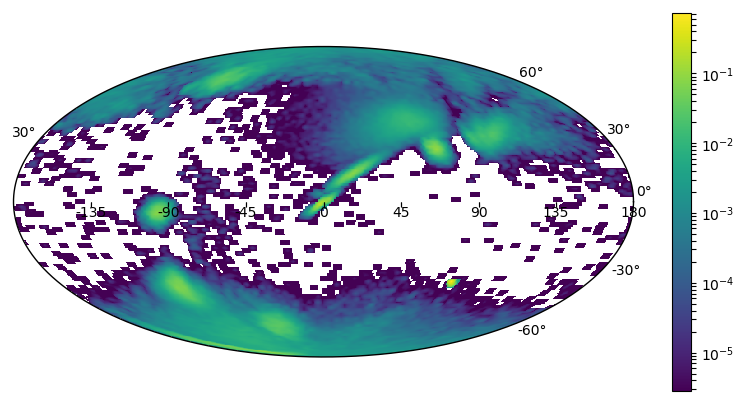

/Users/shouriha/anaconda2/envs/skymaps/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Users/shouriha/anaconda2/envs/skymaps/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0
/Users/shouriha/anaconda2/envs/skymaps/lib/python3.6/site-packages/matplotlib/colors.py:1031: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


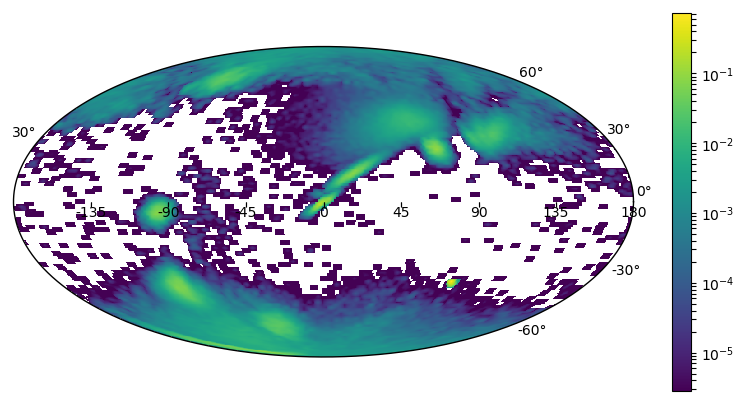

In [38]:
def plotSkyMap(self, percent_sky = 0.1, scale = 'log'):
    from astropy.coordinates import SkyCoord
    from astropy.io import fits
    from astropy import units as u
    import ligo.skymap.plot
    import matplotlib as mpl


    fig = plt.figure(figsize=(10, 5), dpi=100)
    ax = plt.axes(
            projection = 'geo degrees mollweide')

    # Copy shape of healPix
    healPix_sun = self.impact_list[0].healPix_sun * 0

    count = 0
    
    minimum = 1
    maximum = 0
    for i, impact in enumerate(self.impact_list):
        if impact.skyArea_sun > percent_sky * 41253:
            continue
            
        minimum = min(minimum, min(impact.healPix_sun[impact.healPix_sun > 0]))
        maximum = max(maximum, max(impact.healPix_sun))

    norm = mpl.colors.LogNorm(vmin = minimum, vmax = maximum)
    for i, impact in enumerate(self.impact_list):
        
        if impact.skyArea_sun > percent_sky * 41253:
            continue
        count += 1
        healPix_sun += impact.healPix_sun
        #cax = ax.imshow_hpx(impact.healPix_sun, cmap = 'rainbow', norm = norm, alpha = 1) 

    
    if 'log' in scale:
        minimum = min(healPix_sun[healPix_sun > 0])
        norm = mpl.colors.LogNorm(vmin = minimum, vmax = max(healPix_sun))
    else:
        norm = mpl.colors.Normalize(vmin = min(healPix_sun), vmax = max(healPix_sun))

    cax = ax.imshow_hpx(healPix_sun, cmap = 'viridis', norm = norm) 
    fig.colorbar(cax)
    return fig
plotSkyMap(impactList, percent_sky = 0.1, scale = 'log')

    

#### Plot Power Law
Plots and fits a power law given a parameter like 'Ptot', 'lat', 'lon' etc
- `param` : string, which parameter goes on the x axis 
    - default: 'Ptot'
- `credibles`: List of floats < 1, What credible intervals to show
    - default: [0.9]
- `weight`: Bool, whether to weight fit on errors
    - default: True
- `drop_max`: Bool, whether to drop the maximum impact in the fit
    - default: True

In [ ]:
# Without dropping the maxiumum impact
fig, ax = impactList.plotPowerLaw(param = 'Ptot', credibles = [0.99, 0.9, 0.5], weight = True, 
                                  drop_max = False)
ax.set_title('Maximum Impact Kept')


# With dropping the maximum impact
fig, ax = impactList.plotPowerLaw(param = 'Ptot', credibles = [0.99, 0.9, 0.5], weight = True, 
                                   drop_max = True)
ax.set_title('Maximum Impact Dropped')

# We can add the sum of the models line but we need to load the correct data
def lin_func(x, m, b):
    return m * x + b
def power_func(x, a, b):
    return a * (x ** b)

sum_flux = np.zeros(9)
for p in populations:
    # We don't want to include uniform because its made up
    if p.pop_type not in ['JFC', 'HTC', 'AST', 'OCC']:
        continue
        
    # Groupby Momentum
    grouped = p.df.groupby(['Ptot'])['flux'].sum().reset_index()
    # Make Cumulative
    for i in range(len(grouped.index)):
        grouped['flux'][i] = np.sum(grouped['flux'][i:])
        sum_flux[i] += np.sum(grouped['flux'][i:])

# Surface rea of the LPF
Area_SC = 10.377479175382778
# Cross sectional area of the LPF
cross_section_SC = 2
total_time = 168 #days
    
# Fits the model
time = total_time * 24 * 60 * 60 # seconds

# Make momentum array
xdata = np.asarray(grouped['Ptot'].values)
ydata = np.asarray(sum_flux * time * cross_section_SC)
popt, pcov = curve_fit(lin_func, np.log(xdata), np.log(ydata), p0 = (1, 1))
b = popt[0]
a = np.exp(popt[1])
popt = [a, b]
# Sets up points to plot for fit
plot_x = np.logspace(np.log10(min(xdata)), np.log10(max(xdata)), 1000)
        
ax.plot(plot_x, power_func(plot_x, *popt),
        color = 'DarkGreen',#'#92cac6',
        linestyle = ':',
        label = r'Model Fit: %1.2f$(\frac{P}{[\mu N s]})^{%1.2f}$'%(popt[0], popt[1]))

ax.scatter(grouped['Ptot'], ydata, color = 'DarkGreen',#'#92cac6', 
           marker = 'x', s = 50, zorder = 10,
           label = 'Model Prediction' )

ax.set_title('Momentum Population Fit')
ax.legend()


In [ ]:
impactList.plotMomSkyArea(credible = 0.99)


### LaTex Table
Creates a copy and pasteable table for LaTex documents

In [ ]:
# Make Summary table
# Make sure \usepackage{longtable} is at the beginning of the doc
lateX_file = open(BASE_DIR + '/data/lateX_table.tec', 'w+')
summary_table = impactList.summaryTable(percent_sky = 0.1)
lateX_file.write(summary_table)
lateX_file.close()
print(summary_table)


We can also just get one line from the summary table if we'd like

In [ ]:
impactList.impact_list[0].summaryString()